In [2]:
from __future__ import print_function
!pip install -q keras
import keras
import time
from PIL import Image
import numpy as np
import os

Using TensorFlow backend.


In [0]:
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [0]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave, imread, imresize

In [6]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir('drive/app')

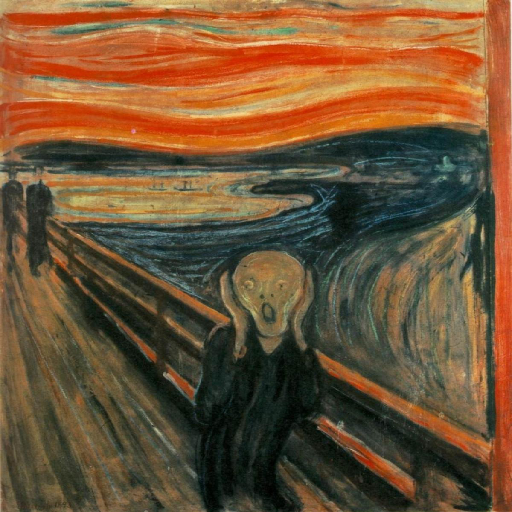

In [9]:
height = 512
width = 512

content_image_path = 'hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

style_image_path_1 = 'starry_night.jpg'
style_image_1 = Image.open(style_image_path_1)
style_image_1 = style_image_1.resize((height, width))
style_image_1

style_image_path_2 = 'The_scream.jpg'
style_image_2 = Image.open(style_image_path_2)
style_image_2 = style_image_2.resize((height, width))
style_image_2

In [10]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
#print(content_array)
print(content_array.shape)

style_array_1 = np.asarray(style_image_1, dtype='float32')
style_array_1 = np.expand_dims(style_array_1, axis=0)
#print(style_array)
print(style_array_1.shape)

style_array_2 = np.asarray(style_image_2, dtype='float32')
style_array_2 = np.expand_dims(style_array_2, axis=0)
#print(style_array)
print(style_array_2.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

content_array = content_array[:, :, :, ::-1]

style_array_1[:, :, :, 0] -= 103.939
style_array_1[:, :, :, 1] -= 116.779
style_array_1[:, :, :, 2] -= 123.68

style_array_1 = style_array_1[:, :, :, ::-1]

style_array_2[:, :, :, 0] -= 103.939
style_array_2[:, :, :, 1] -= 116.779
style_array_2[:, :, :, 2] -= 123.68

style_array_2 = style_array_2[:, :, :, ::-1]

In [0]:
content_image = backend.variable(content_array)

style_image_1 = backend.variable(style_array_1)
style_image_2 = backend.variable(style_array_2)

new_combination_image = backend.placeholder((1, height, width, 3))

In [0]:
input_tensor = backend.concatenate([content_image, style_image_1, style_image_2, new_combination_image], axis=0)

In [14]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [15]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(4, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(4, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(4, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(4, 64, 64, 512) dtype=float32>,
 'b

In [0]:
content_image_weight = 0.02
style_image_1_weight = 25.0
style_image_2_weight = 25.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

In [0]:
def content_loss(content, new_content):
    return backend.sum(backend.square(new_content - content))

In [19]:
layer_features = layers['block2_conv1']
content_image_features = layer_features[0, :, :, :]
new_combination_image_features = layer_features[3, :, :, :]


loss += content_loss(content=content_image_features, new_content=new_combination_image_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
    
def style_loss(style, new_style):
    S = gram_matrix(style)
    NS = gram_matrix(new_style)
    
    channels = 3
    size = height * width
    
    return backend.sum(backend.square(S - NS)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features_1 = layer_features[1, :, :, :]
    style_features_2 = layer_features[2, :, :, :]
    new_combination_image_features = layer_features[3, :, :, :]
    sl_1 = style_loss(style_features_1, new_combination_image_features)
    sl_2 = style_loss(style_features_2, new_combination_image_features)
    loss += (style_image_1_weight / len(feature_layers)) * sl_1 + (style_image_2_weight / len(feature_layers)) * sl_2

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [0]:
loss += total_variation_weight * total_variation_loss(new_combination_image)

In [0]:
#grads = backend.gradients(loss, new_content_image)
#grads = backend.gradients(loss, new_style_image)
grads = backend.gradients(loss, new_combination_image)

In [0]:
outputs = [loss]
outputs += grads

#f_outputs = backend.function([new_content_image], outputs)

#f_outputs = backend.function([new_style_image], outputs)

f_outputs = backend.function([new_combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

In [28]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128

iterations = 10

for i in range(iterations):
    print('Start of iterations of ', i)
    
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    
    print('Current loss value: ', min_val)
    
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
    iter_x = np.copy(x)
    iter_x = iter_x.reshape((height, width, 3))
    iter_x = iter_x[:, :, ::-1]
    iter_x[:, :, 0] += 103.939
    iter_x[:, :, 1] += 116.779
    iter_x[:, :, 2] += 123.68
    iter_x = np.clip(iter_x, 0, 255).astype('uint8')
    
    Image.fromarray(iter_x)
    
imsave('final.jpg', iter_x)

Start of iterations of  0
Current loss value:  3555089200000.0
Iteration 0 completed in 31s
Start of iterations of  1
Current loss value:  2870946300000.0
Iteration 1 completed in 25s
Start of iterations of  2
Current loss value:  2707479300000.0
Iteration 2 completed in 26s
Start of iterations of  3
Current loss value:  2653149000000.0
Iteration 3 completed in 26s
Start of iterations of  4
Current loss value:  2625770600000.0
Iteration 4 completed in 26s
Start of iterations of  5
Current loss value:  2608371600000.0
Iteration 5 completed in 26s
Start of iterations of  6
Current loss value:  2598853400000.0
Iteration 6 completed in 26s
Start of iterations of  7
Current loss value:  2593090400000.0
Iteration 7 completed in 26s
Start of iterations of  8
Current loss value:  2589078600000.0
Iteration 8 completed in 26s
Start of iterations of  9
Current loss value:  2586535500000.0
Iteration 9 completed in 26s
